In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/home/snikolenko/soft/lectures/lectures/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Выбор модели в полиномиальной регрессии

In [9]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

## Обучаем модель с регуляризацией
@ignore_warnings(category=ConvergenceWarning)
def train_model(xs, ys, alpha=0, use_lasso=False):
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

[ 1.52748415  0.09609146 -0.4982683 ]
[ 1.89602369 -0.48427164 -0.73438581  0.22113916]


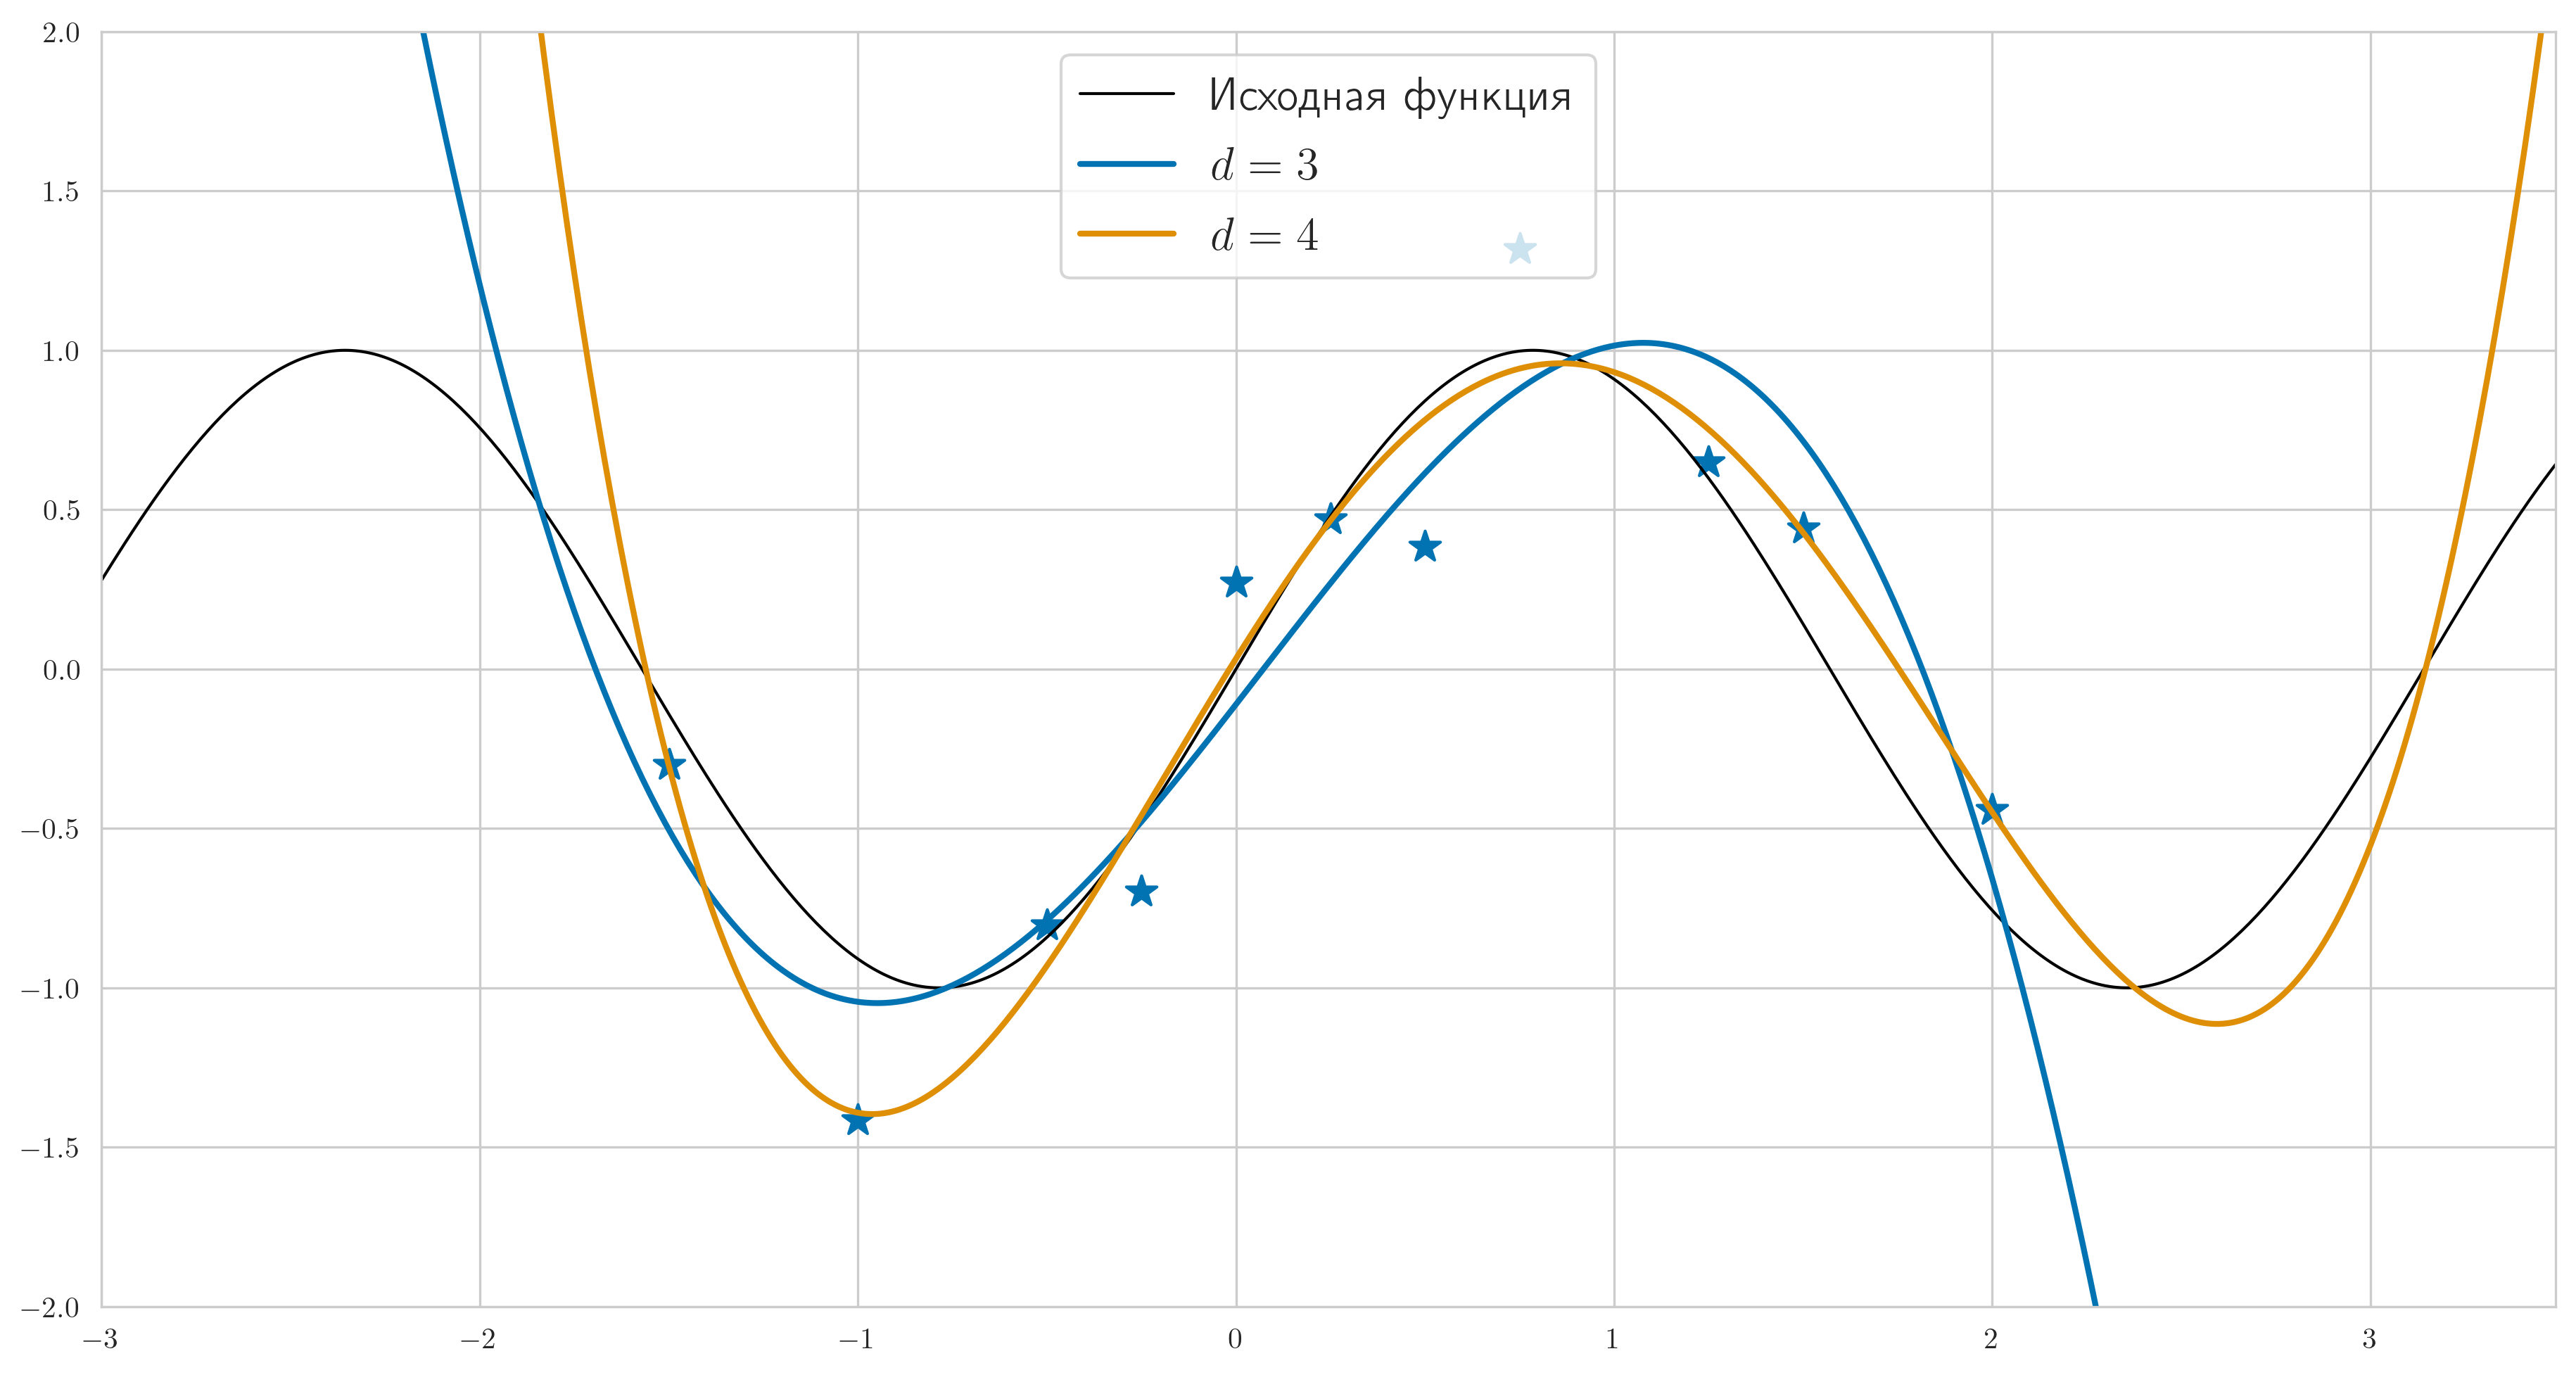

In [10]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [ 3, 4 ]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = train_model( xd_d[:, :d], data )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper center", fontsize=legend_fontsize)

plt.show()

In [11]:
models = [ train_model( xd_d[:, :d], data ) for d in range(1, 11) ]


In [12]:
def logL(model, xs, ys):
    yfit = model.predict(xs)
    return np.sum([ sp.stats.norm.logpdf(ys[i], loc=yfit[i], scale=.25) for i in range(ys.shape[0]) ])

logLs = [logL(models[d-1], xd_d[:,:d], data) for d in range(1, 11)]

In [13]:
def BIC(ll, N, k):
    return -2*ll + np.log(N)*k

bics = [BIC(logLs[d-1], data.shape[0], d) for d in range(1, 11)]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
# ax.set_xlim((xs[0], xs[-1]))
# ax.set_ylim((-2, 2))
ax.plot(range(1, 11), logLs, label="Log likelihood", linewidth=2)
ax.plot(range(1, 11), bics, label="BIC", linewidth=2)
ax.legend(fontsize=legend_fontsize)
plt.show()

## Статистическая теория принятия решений

In [22]:
N = 1500
alpha =  01.0
use_lasso = False

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-3, 3))

res = []
for _ in range(N):
    cur_data = orig(xd) + np.random.normal(0, .25, num_points)
    cur_model = train_model(xd_d, cur_data, alpha, use_lasso)
    res.append(cur_model.predict( xs_d ))
    ax.plot(xs, res[-1], linewidth=.15, color="0.5")

ax.plot(xs, orig(xs), linewidth=2, label="Исходная функция", color=palette[0])
ax.scatter(xd, orig(xd), marker='*', s=150, color=palette[0])

ax.plot(xs, np.mean( res, axis=0 ), linewidth=2, label="Усреднённые предсказания", color="red")
ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], data )

In [18]:
test_set_size = 50
test_set_x = np.random.rand(test_set_size) * (2 + 1.5) - 1.5
test_set_xs = np.vstack([test_set_x ** i for i in range(1, 12)]).transpose()
print(test_set_xs.shape)
test_set_y = orig(test_set_xs[:,0]) + np.random.normal(0, .25, test_set_size)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(xs, orig(xs), linewidth=2, label="Исходная функция", color=palette[0])
ax.scatter(test_set_xs[:,0], test_set_y, marker='*', s=150, color=palette[0])
ax.set_xlim((-1.5, 2))

def test_set_error(model, d):
    return np.mean( (test_set_y - model.predict(test_set_xs[:, :d])) ** 2 )

(50, 11)


In [19]:
N = 5000
use_lasso=False
alphas = np.logspace(-4, 2, num=20)
errors, biases, variances = [], [], []
for alpha in alphas:
    res, res_preds, res_test = [], [], []
    for _ in range(N):
        cur_data = orig(xd) + np.random.normal(0, .25, num_points)
        cur_model = train_model(xd_d, cur_data, alpha, use_lasso)
        res.append(test_set_error(cur_model, xd_d.shape[1]))
        res_test.append(cur_model.predict(test_set_xs))
        res_preds.append(cur_model.predict( xs_d ))
    res_test = np.array(res_test)
    avg_preds = np.mean(res_test, axis=0)
    errors.append(np.mean(res))
    biases.append(np.mean((avg_preds-orig(test_set_x))**2))
    variances.append(np.mean((res_test-avg_preds)**2))
    print("alpha = %.6f\tmean error = %.6f\tbias = %.6f\tvariance = %.6f" % (alpha, errors[-1], biases[-1], variances[-1]))

alpha = 0.000100	mean error = 6.061904	bias = 0.004963	variance = 5.986459
alpha = 0.000207	mean error = 4.481003	bias = 0.002560	variance = 4.405907
alpha = 0.000428	mean error = 2.526636	bias = 0.001247	variance = 2.450824
alpha = 0.000886	mean error = 1.388647	bias = 0.006129	variance = 1.310790
alpha = 0.001833	mean error = 0.816946	bias = 0.007355	variance = 0.735408
alpha = 0.003793	mean error = 0.552377	bias = 0.010659	variance = 0.465712
alpha = 0.007848	mean error = 0.426981	bias = 0.014406	variance = 0.333985
alpha = 0.016238	mean error = 0.360628	bias = 0.020754	variance = 0.259508
alpha = 0.033598	mean error = 0.310238	bias = 0.022667	variance = 0.206816
alpha = 0.069519	mean error = 0.263489	bias = 0.020621	variance = 0.163102
alpha = 0.143845	mean error = 0.219057	bias = 0.016653	variance = 0.128077
alpha = 0.297635	mean error = 0.197330	bias = 0.023681	variance = 0.108672
alpha = 0.615848	mean error = 0.200679	bias = 0.057161	variance = 0.088806
alpha = 1.274275	mean err

In [20]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
# plt.yscale('log')
plt.xscale('log')
ax.plot(alphas, biases, linewidth=2, label="Bias")
ax.plot(alphas, variances, linewidth=2, label="Variance")
ax.plot(alphas, np.array(biases) + np.array(variances), linewidth=2, label="Bias + Variance")
ax.plot(alphas, errors, linewidth=2, label="Ошибка на тестовом множестве", color="black")
ax.set_ylim((0, 1))
ax.set_xlim((0.001, 100))
ax.legend(fontsize=legend_fontsize)
# fig.savefig('statdecision1.pdf', bbox_inches='tight')

## Эквивалентное ядро в линейной регрессии

[-0.30015299 -1.41544625 -0.80437243 -0.69804864  0.27140066  0.47056374
  0.38455893  1.31669724  0.64760619  0.44005206 -0.44242323]
[-0.30015299 -1.41544625 -0.80437243 -0.69804864  0.27140066  0.47056374
  0.38455893  0.          0.64760619  0.44005206 -0.44242323]
[0.10591131]


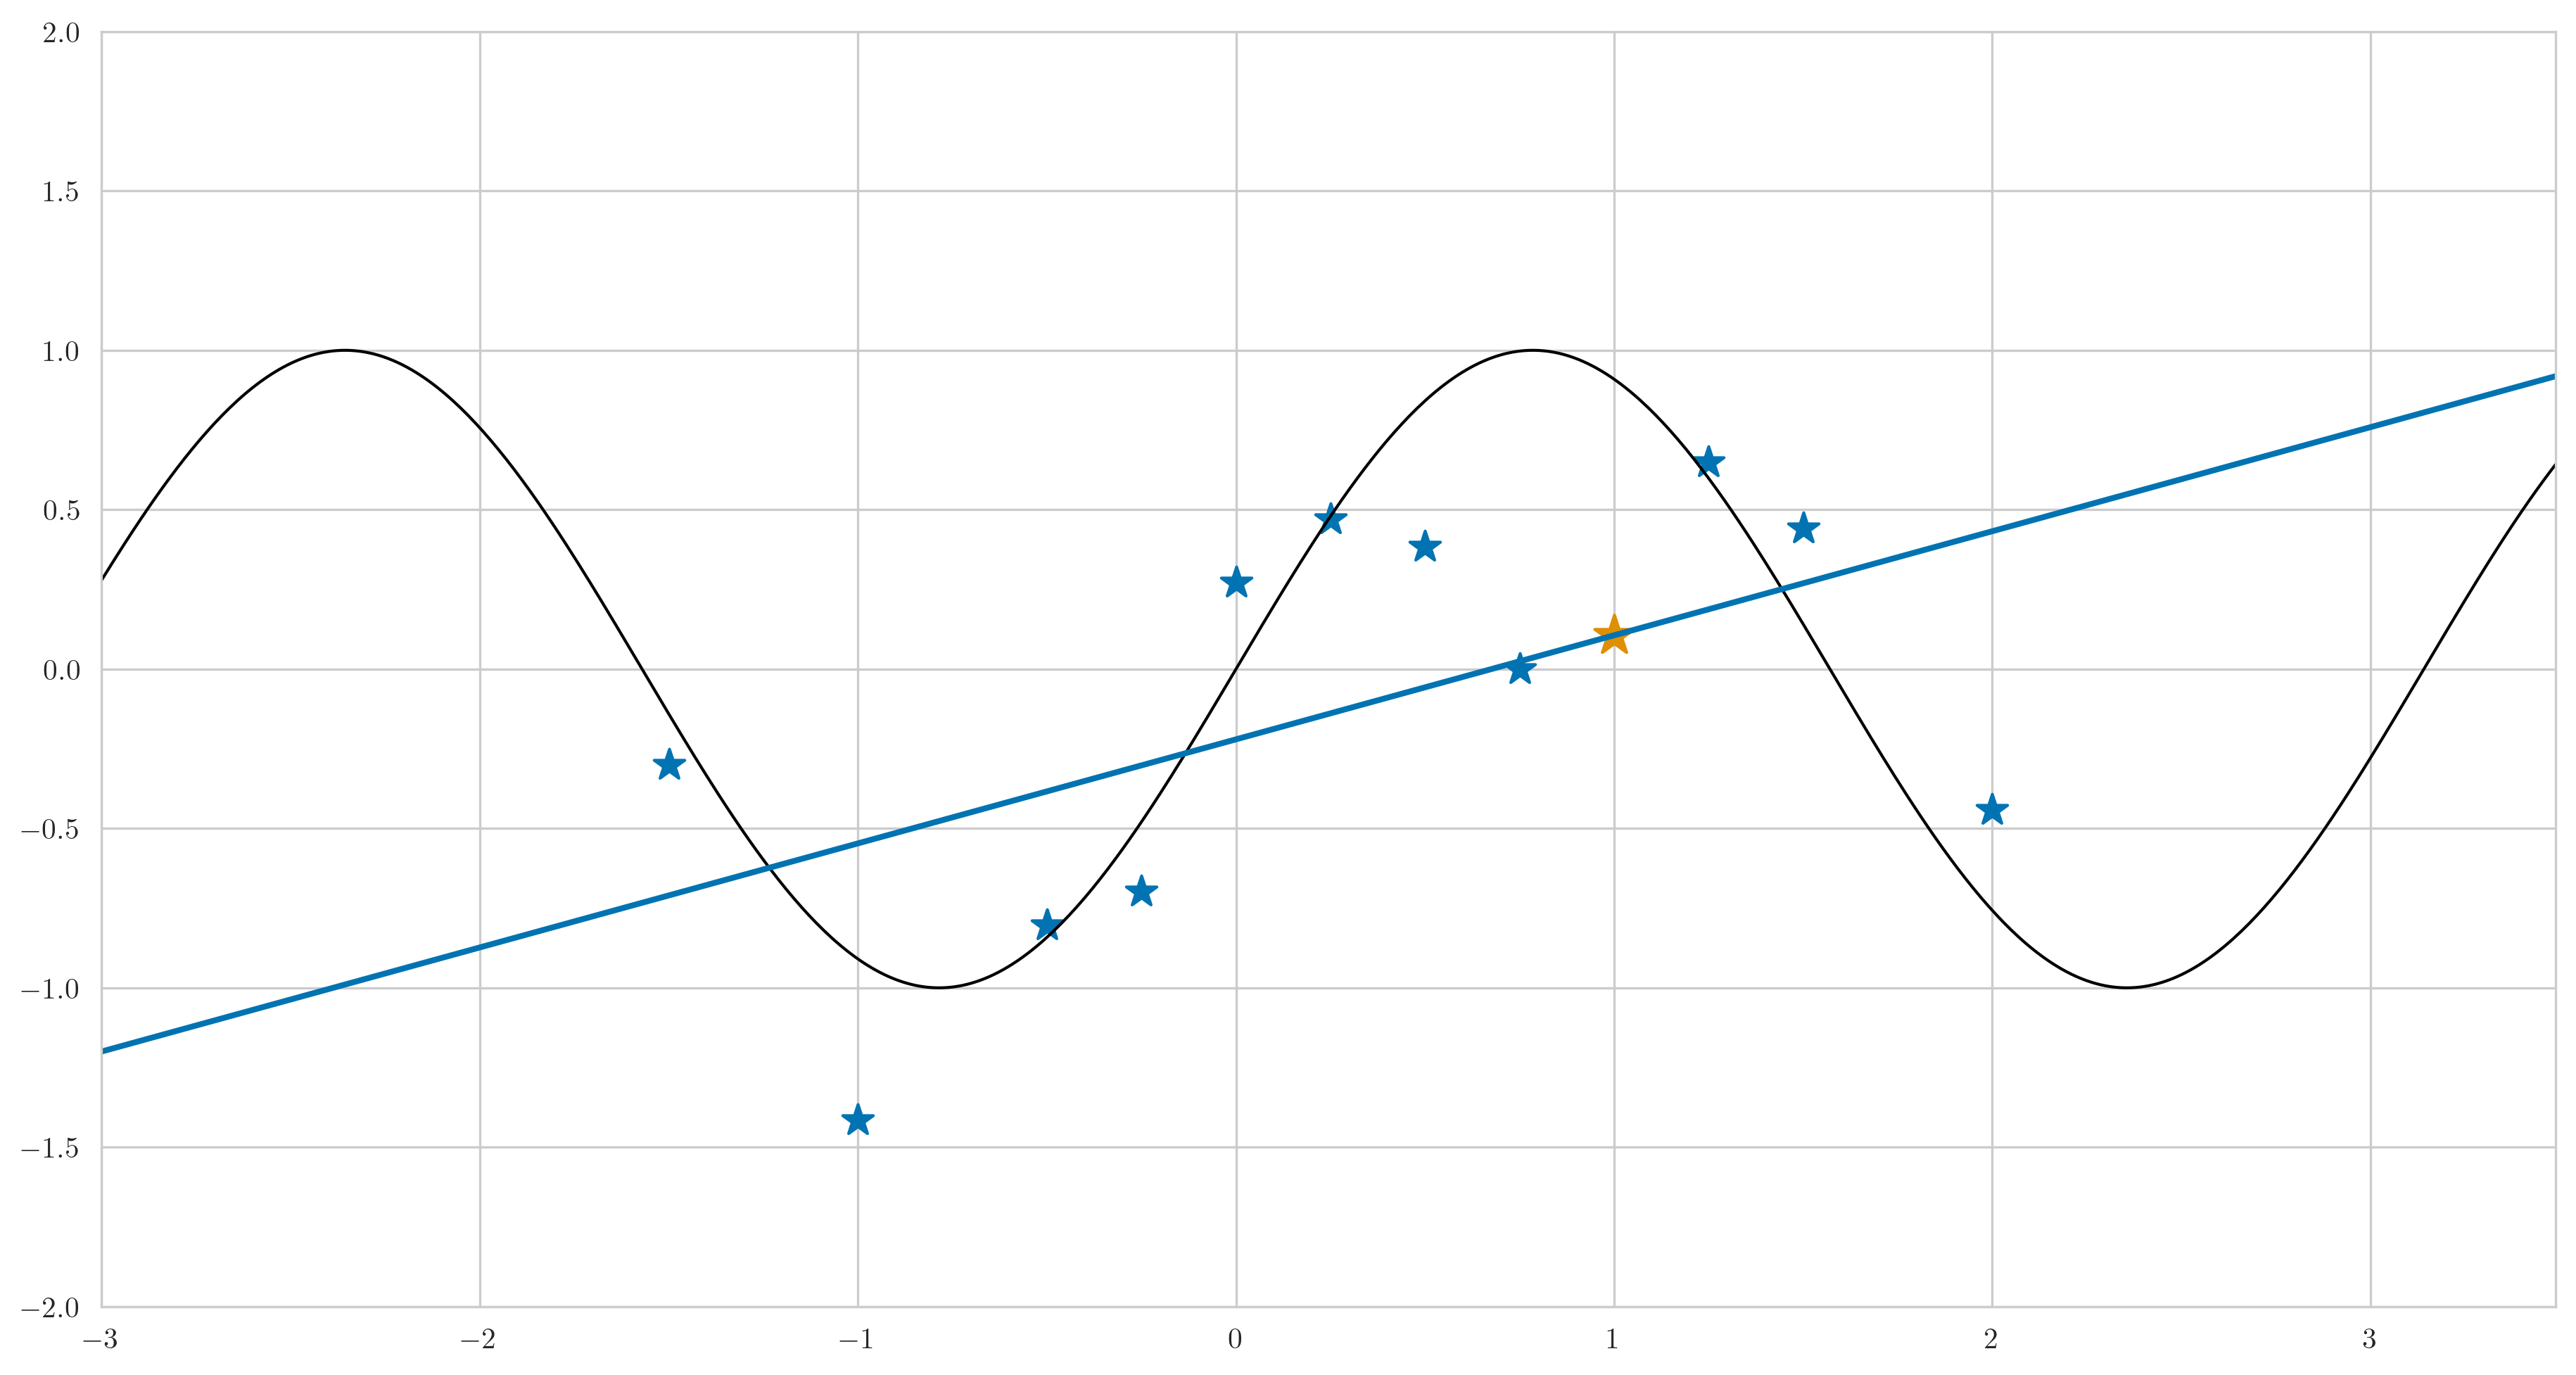

In [14]:
d = 1
x_pred = 1

new_data = np.copy(data)
new_data[7] = 0
cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], new_data )

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, new_data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")
ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)
y_pred = cur_model.predict(np.array([x_pred]).reshape(1,-1))
ax.scatter(x_pred, y_pred, marker='*', s=200)


print(data)
print(new_data)
print(y_pred)

In [16]:
def get_one_prediction(x_pred, cur_y, d=1, data_ind=7, data=data):
    new_data = np.copy(data)
    new_data[data_ind] = cur_y
    cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], new_data )
    return cur_model.predict(np.array([x_pred]).reshape(1,-1))[0]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ys = np.arange(-1, 1, 0.1)
ax.set_xlim((ys[0], ys[-1]))

for x_pred in [-.5, 1, 1.5, 2]:
    one_pred = [ get_one_prediction(x_pred, y) for y in ys ]
    ax.plot(ys, one_pred, linewidth=2, label="Предсказание в точке %.2f" % x_pred)

ax.legend(fontsize=legend_fontsize)